# TP3 - Frequency Domain
ATRIM - Option Datasim

Ecole Centrale Nantes

Diana Mateus

Participants: Yueying CAO

## GOAL

In this lab we will:
- put into practice the computation of the DFT of an image, and learn to interpret the result. 
- Design and apply bandpass and Notch filters. 
- Replicate the use of the DCT for image compression in Jpeg.

## 0. Preparation 

### 0.1 Import the required modules


In [1]:
from scipy import ndimage
from scipy import misc
import matplotlib.pyplot as plt
import numpy as np
import os
import skimage.io as io
from skimage.transform import resize

### 0.2 Define the main image folder
Make sure the subsequent parts of this notebook refer to this definition IMDIR. **When evaluating your notebook I should only need to change the path here** to run the entire notebook.

In [2]:
IMDIR = "./images/"
print(os.listdir(IMDIR))


['Fourier', 'Frequency', 'jpeg', 'PhaseMag']


## 1. The Discrete Fourier Transform



### 1.1 Computing and visualizing the DFT  


In this exercise we will compute and visualize a DFT using numpy's fft functions:
- ```np.fft.fft2```: computes the two-dimensional FFT of an image.
- ```np.fft.fftshift```: center the frecuencies in the middle of the image
- ```np.fft.ifftshift```: reverses the centering
- ```np.fft.ifft2```: inverse fourier transform
- ```np.real```: takes the real components of a complex number
- ```np.abs```: recovers the magnitude of a complex number
- ```np.angle```: recovers the phase of a complex number 
- ```np.log```: computes the logarithm

Apply the functions above to the images in the ```Fourier``` folder. Display in a single row for each image:

**a)** the original image 

**b)** the magnitude of its fft (scaled logarithmically)

**c)** the magnitude of its **centered(shifted)** fft (scaled logarithmically)

**c)** the inverse fft of the above transformed image (all the steps shouls be reversed)

**d) For each image explain how the information in the image relates to its representation in the frequency domain**




**In the report:** Resume the steps and explain the DFTs for each image

./images/Fourier\house.gif


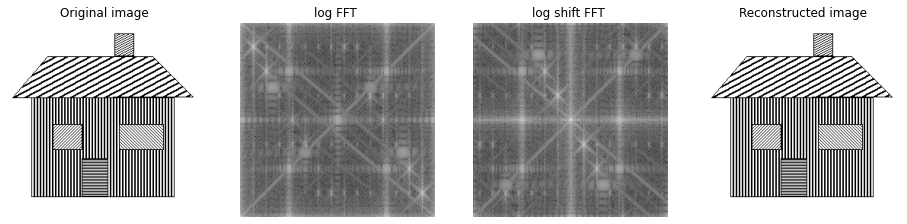

./images/Fourier\squares.png


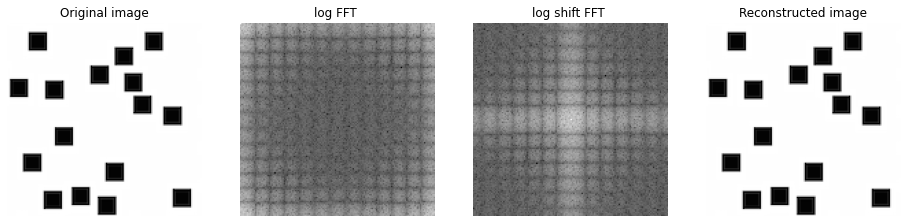

./images/Fourier\textures.jpg


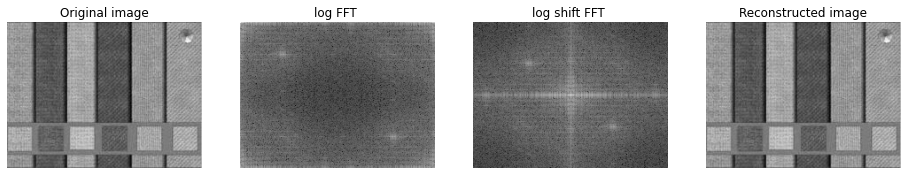

./images/Fourier\tiled.png


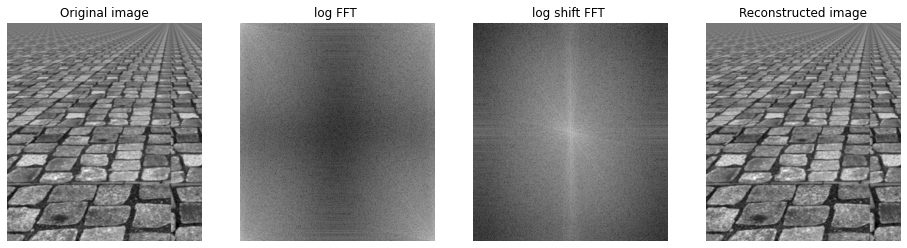

./images/Fourier\zebra-wall.png


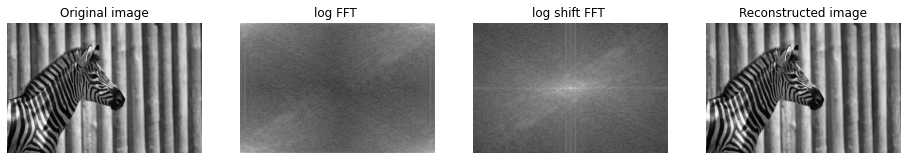

In [4]:
SUBDIR = os.path.join(IMDIR, "Fourier")


for root, dirnames, filenames in os.walk(SUBDIR):
    # print path to all filenames.
    for filename in filenames:
        f = os.path.join(root, filename)
        if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):
            print(f)
            im = io.imread(f,as_gray=True)
            if im.shape[0]<100 and im.shape[1]<100:
                im = resize(im,(100,100),mode='constant') # RESIZE IF TOO SLOW                         
            
            plt.rcParams['figure.figsize']=[16,18]

            plt.subplot(141)
            plt.title('Original image')
            plt.imshow(im,cmap='gray')
            plt.axis('off')
            
            im_fft = np.fft.fft2(im)
            
            plt.subplot(142)
            plt.title('log FFT ')
            plt.imshow(np.log(np.abs(im_fft)),cmap='gray') 
            plt.axis('off')
                        
            plt.subplot(143)
            plt.title('log shift FFT ')
            im_fft_shift = np.fft.fftshift(im_fft)
            plt.imshow(np.log(np.abs(im_fft_shift)),cmap='gray')
            plt.axis('off')

            
            plt.subplot(144)
            plt.title('Reconstructed image')
            im_re = np.real(np.fft.ifft2(np.fft.ifftshift(im_fft_shift)))
            plt.imshow(im_re,cmap='gray')
            plt.axis('off')
            
            plt.show()

## 2. Filtering in the frequency domain
**a)** Implement two functions that create a low pass and a high-pass filter in frequency space for a given cutoff frequency $D_0$. The functions should receive as input parameter the type of filter: 'ideal' or 'gaussian', and the filter parameters.

**b)** Show the filter frequency responses for different values of the cuttoff frequency both for the gaussian and the ideal filters. 

**c)** Filter **ONE** of the images in the ```freqfilt``` folder with the implemented functions. 

**d)** For the image in c) Show the results of the low and high pass filters  both in the frequency and the spatial domain.

**e)** Show and compare the results from the ideal and the Gaussian filter. 
**Question**: Are there any observable differences? (write answers in the ANSWERS block below)

**f)** **Question**: What happens with the DC component after a highpass filter has been applied?

**g)** Design and apply the right filter to do the following tasks:
- remove the noise of ```tower.jpg```
- smooth out the freckles of trying to keep the face sharp ```face1.jpg```
- remove out the moire pattern from  ```car-moire-pattern.tif```
- highlight the wrinkles of ```face2.jpg```
- remove the interference pattern of ```astronaut-interference.tif```
- remove the shadow from the ```text-spotshade.tif```

**Explain** the filter choice, show the spatial and frequency response and comment your findings.


**IN THE REPORT** Answer questions e), f) and g) 


In [5]:
# a) two functions that create low/high pass filter
def low_pass(P, Q, filter_type, D0, p=0, q=0):
    # p,q here is to change the center of the filter for notch filter
    # default filter is centered at the center of the pad image
    if p==0 and q==0:
        p = P/2
        q = Q/2
    D = np.zeros((P,Q))
    H = np.copy(D)
    for i in range(P):
        for j in range(Q):
            D[i,j] = np.sqrt((i-p)**2 + (j-q)**2)
            if filter_type =='ideal':
                if D[i,j] < D0:
                    H[i,j] = 1
                else:
                    H[i,j] = 0
            elif filter_type =='gaussian':
                H[i,j] = np.exp(-D[i,j]**2/(2*D0**2))
            else: 
                print('Please input the type of the filter, Gaussian or Ideal')
                
    return H
            
def high_pass(P, Q, filter_type, D0, p=0, q=0):
    if p==0 and q==0:
        p = P/2
        q = Q/2
    H = 1 - low_pass(P, Q, filter_type, D0, p, q)
    
    return H
    
def band_pass(P, Q, filter_type, D0,W=5, p=0, q=0):
    if p==0 and q==0:
        p = P/2
        q = Q/2
    D = np.zeros((P,Q))
    H = np.copy(D)
    for i in range(P):
        for j in range(Q):
            D[i,j] = np.sqrt((i-p)**2 + (j-q)**2)
            H[i,j] = 1-np.exp(-(((D[i,j]**2-D0**2)/(W*D[i,j]))**2))
    return H

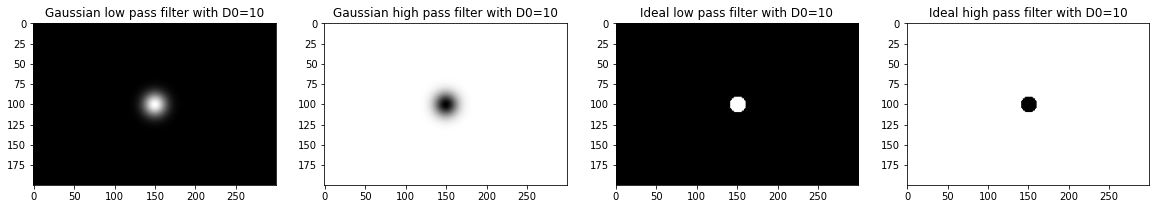

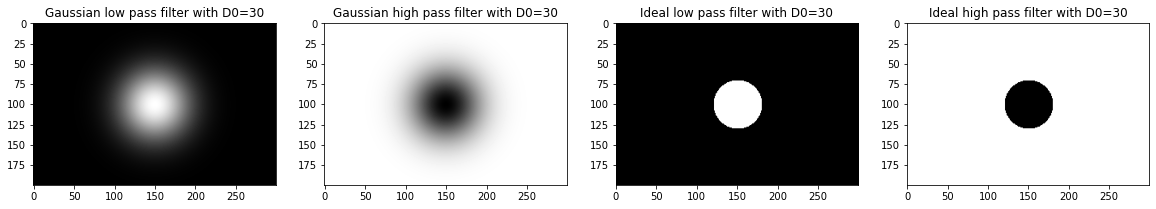

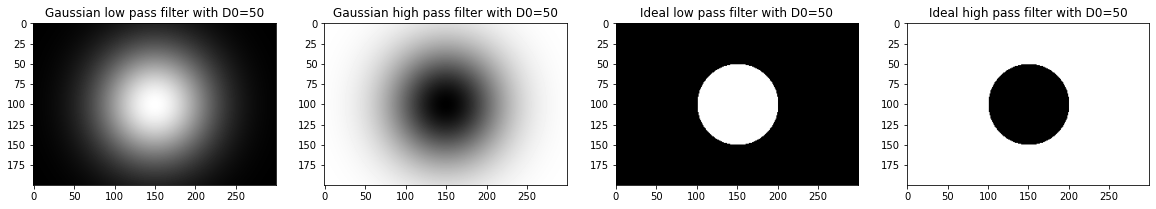

In [6]:
# b) Show the filter frequency responses for different values of the cuttoff frequency
width=20
height=15
plt.rcParams['figure.figsize'] = [width, height]

P = 200
Q = 300
D0 = 10

for i in range(3):
    plt.figure()
    plt.subplot(1,4,1)
    H = low_pass(P, Q, 'gaussian', D0)
    plt.imshow(H, cmap='gray')
    plt.title('Gaussian low pass filter with D0='+str(D0))
    
    plt.subplot(1,4,2)
    H = high_pass(P, Q, 'gaussian', D0)
    plt.imshow(H, cmap='gray')
    plt.title('Gaussian high pass filter with D0='+str(D0))
    
    plt.subplot(1,4,3)
    H = low_pass(P, Q, 'ideal', D0)
    plt.imshow(H, cmap='gray')
    plt.title('Ideal low pass filter with D0='+str(D0))
    
    plt.subplot(1,4,4)
    H = high_pass(P, Q, 'ideal', D0)
    plt.imshow(H, cmap='gray')
    plt.title('Ideal high pass filter with D0='+str(D0))
    
    D0 = D0 + 20
    

<ipython-input-7-bc93ab476b69>:57: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(G_high)),cmap='gray')
<ipython-input-7-bc93ab476b69>:86: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(G_low)),cmap='gray')
<ipython-input-7-bc93ab476b69>:97: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(G_high)),cmap='gray')


(-0.5, 741.5, 739.5, -0.5)

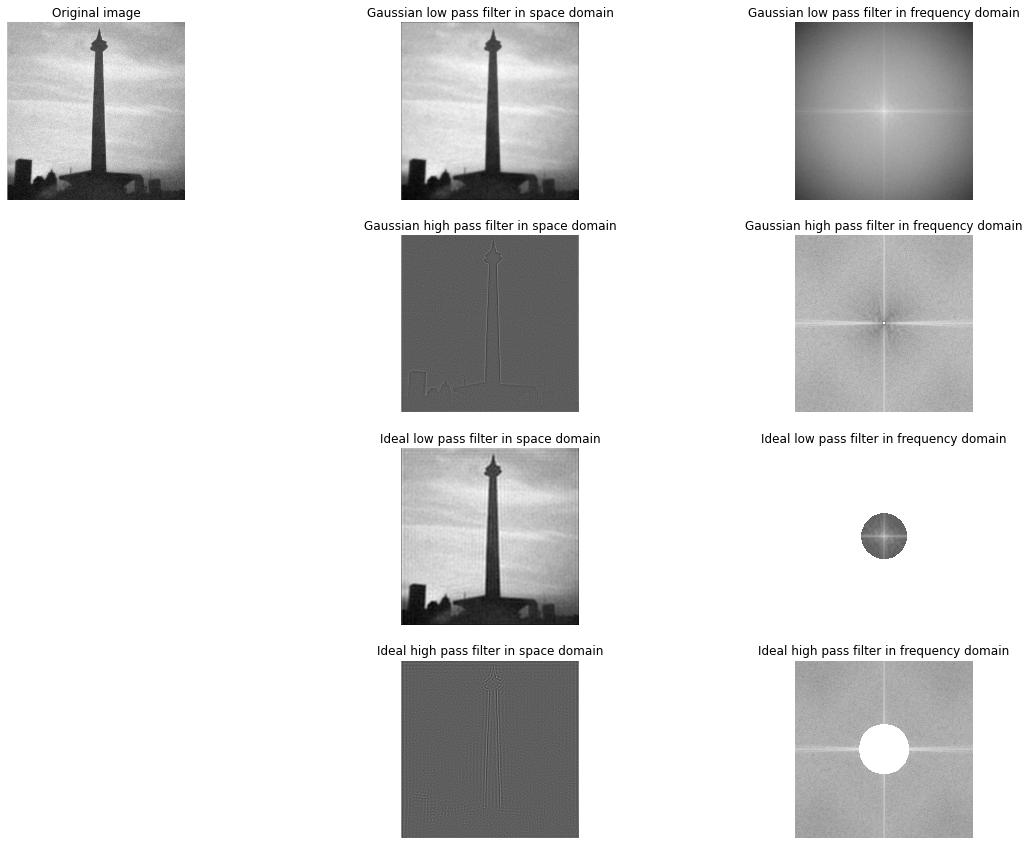

In [7]:
# c,d,) Filter ONE of the images in the freqfilt folder with the implemented functions.
loc = IMDIR+'Frequency/tower.jpg'
img = io.imread(loc, as_gray=True)

# step1: padding
P = img.shape[0]*2
Q = img.shape[1]*2
img_pad = np.zeros((P,Q))
img_pad[0:img.shape[0],0:img.shape[1]] = img

# step2: Compute the DFT and shift to the center
img_fft = np.fft.fft2(img_pad)
img_shift = np.fft.fftshift(img_fft)

# step3: Construct a real, symmetric filter
# ----------------------------------------- gaussian filter -----------------------------------------
D0 = 100
fil_type = 'gaussian'
H_low = low_pass(P, Q, fil_type, D0)
H_high = high_pass(P, Q, fil_type, D0)

# step4: Compute the product
G_low = H_low*img_shift
G_high = H_high*img_shift

# step5: Obtained the fitered image by computing the IDFT
img_low = np.real(np.fft.ifft2(np.fft.ifftshift(G_low))) 
img_high = np.real(np.fft.ifft2(np.fft.ifftshift(G_high)))

# step6: Extract the image region
img_low = img_low[0:img.shape[0],0:img.shape[1]]
img_high = img_high[0:img.shape[0],0:img.shape[1]]

plt.figure()
plt.subplot(4,3,1)
plt.imshow(img,cmap='gray')
plt.title('Original image')
plt.axis('off')

plt.subplot(4,3,2)
plt.imshow(img_low,cmap='gray')
plt.title('Gaussian low pass filter in space domain')
plt.axis('off')

plt.subplot(4,3,3)
plt.imshow(np.log(np.abs(G_low)),cmap='gray')
plt.title('Gaussian low pass filter in frequency domain')
plt.axis('off')


plt.subplot(4,3,5)
plt.imshow(img_high,cmap='gray')
plt.title('Gaussian high pass filter in space domain')
plt.axis('off')

plt.subplot(4,3,6)
plt.imshow(np.log(np.abs(G_high)),cmap='gray')
plt.title('Gaussian high pass filter in frequency domain')
plt.axis('off')


# -------------------------------------------- ideal filter -----------------------------------------
fil_type = 'ideal'
H_low = low_pass(P, Q, fil_type, D0)
H_high = high_pass(P, Q, fil_type, D0)

# step4: Compute the product
G_low = H_low*img_shift
G_high = H_high*img_shift

# step5: Obtained the fitered image by computing the IDFT
img_low = np.real(np.fft.ifft2(np.fft.ifftshift(G_low))) 
img_high = np.real(np.fft.ifft2(np.fft.ifftshift(G_high)))

# step6: Extract the image region
img_low = img_low[0:img.shape[0],0:img.shape[1]]
img_high = img_high[0:img.shape[0],0:img.shape[1]]


plt.subplot(4,3,8)
plt.imshow(img_low,cmap='gray')
plt.title('Ideal low pass filter in space domain')
plt.axis('off')

plt.subplot(4,3,9)
plt.imshow(np.log(np.abs(G_low)),cmap='gray')
plt.title('Ideal low pass filter in frequency domain')
plt.axis('off')


plt.subplot(4,3,11)
plt.imshow(img_high,cmap='gray')
plt.title('Ideal high pass filter in space domain')
plt.axis('off')

plt.subplot(4,3,12)
plt.imshow(np.log(np.abs(G_high)),cmap='gray')
plt.title('Ideal high pass filter in frequency domain')
plt.axis('off')

(-0.5, 741.5, 739.5, -0.5)

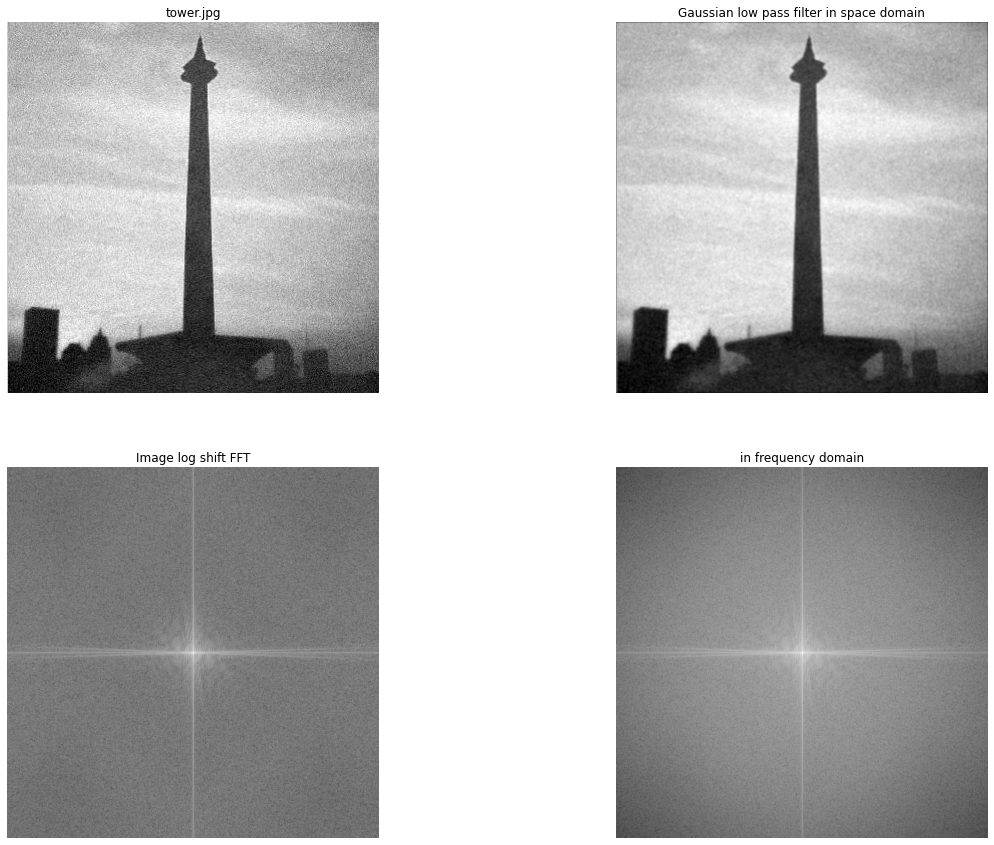

In [8]:
# g) Design and apply the right filter to do the following tasks
## 1. remove the noise of tower.jpg
loc = IMDIR+'Frequency/tower.jpg'
img = io.imread(loc, as_gray=True)

P = img.shape[0]*2
Q = img.shape[1]*2

img_pad = np.zeros((P,Q))
img_pad[0:img.shape[0],0:img.shape[1]] = img

img_fft = np.fft.fft2(img_pad)
img_shift = np.fft.fftshift(img_fft)

D0 = 150
fil_type = 'gaussian'
H_low = low_pass(P, Q, fil_type, D0)
G_low = H_low*img_shift
img_low = np.real(np.fft.ifft2(np.fft.ifftshift(G_low))) 
img_low = img_low[0:img.shape[0],0:img.shape[1]]

plt.figure()
plt.subplot(2,2,1)
plt.imshow(img, cmap='gray')
plt.title('tower.jpg')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(np.log(np.abs(img_shift)), cmap='gray')
plt.title('Image log shift FFT')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(img_low,cmap='gray')
plt.title('Gaussian low pass filter in space domain')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(np.log(np.abs(G_low)),cmap='gray')
plt.title('in frequency domain')
plt.axis('off')


(-0.5, 246.5, 266.5, -0.5)

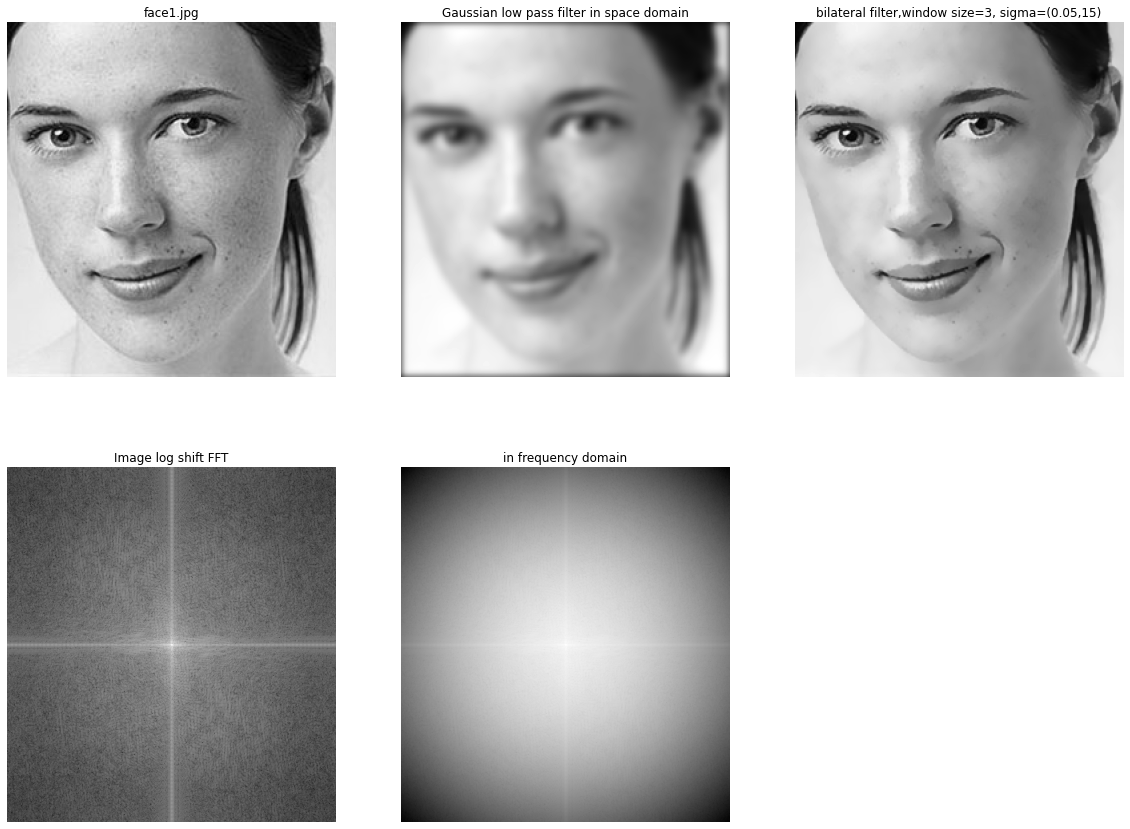

In [9]:
## 2. smooth out the freckles of trying to keep the face sharp face1.jpg
from skimage.restoration import denoise_bilateral

loc = IMDIR+'Frequency/face1.jpg'
img = io.imread(loc, as_gray=True)

plt.figure()
plt.subplot(2,3,1)
plt.imshow(img, cmap='gray')
plt.title('face1.jpg')
plt.axis('off')


P = img.shape[0]*2
Q = img.shape[1]*2
img_pad = np.zeros((P,Q))
img_pad[0:img.shape[0],0:img.shape[1]] = img
img_fft = np.fft.fft2(img_pad)
img_shift = np.fft.fftshift(img_fft)


H_low = low_pass(P, Q, 'gaussian', 30)
G_low = H_low*img_shift
img_low = np.real(np.fft.ifft2(np.fft.ifftshift(G_low))) 
img_low = img_low[0:img.shape[0],0:img.shape[1]]

plt.subplot(2,3,4)
plt.imshow(np.log(np.abs(img_shift)), cmap='gray')
plt.title('Image log shift FFT')
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(img_low,cmap='gray')
plt.title('Gaussian low pass filter in space domain')
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(np.log(np.abs(G_low)),cmap='gray')
plt.title('in frequency domain')
plt.axis('off')

plt.subplot(2,3,3)
img_bilateral = denoise_bilateral(img, win_size=3*2+1, sigma_color=0.05, sigma_spatial=15)
plt.imshow(img_bilateral, cmap='gray')
plt.title('bilateral filter,window size=3, sigma=(0.05,15)')
plt.axis('off')

<ipython-input-10-71c824723db7>:53: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(G)), cmap='gray')
<ipython-input-10-71c824723db7>:73: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(G)), cmap='gray')


(-0.5, 167.5, 245.5, -0.5)

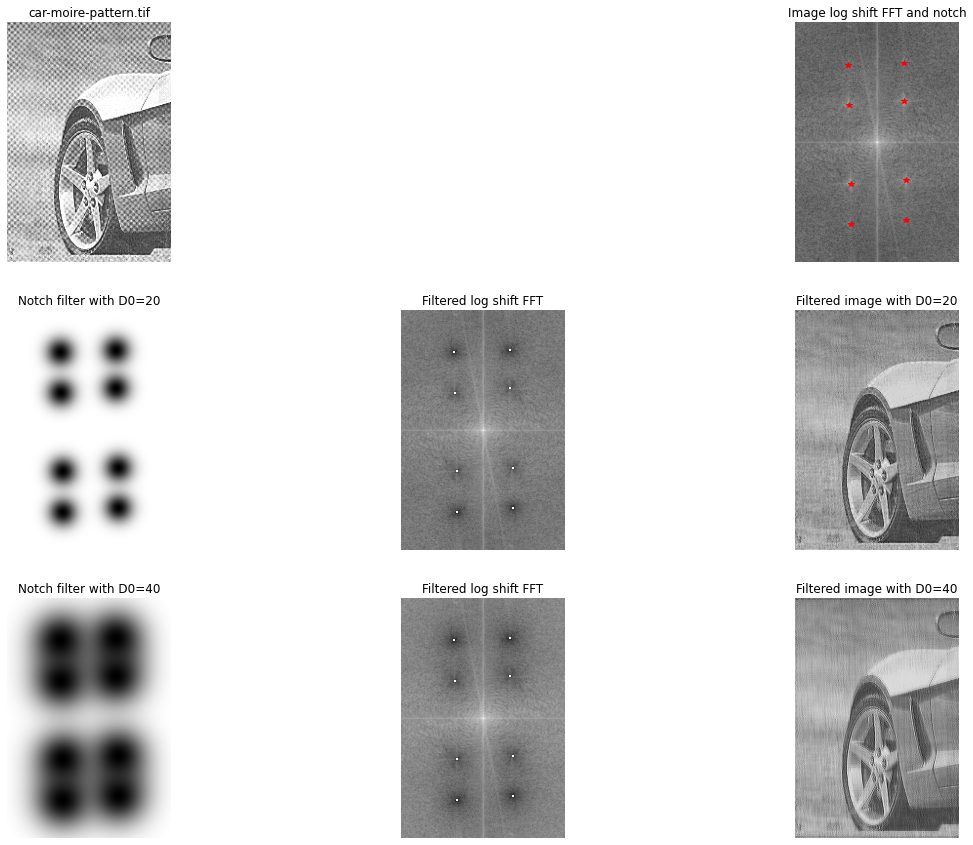

In [10]:
## 3. remove out the moire pattern from car-moire-pattern.tif
# Notch Filtering
loc = IMDIR+'Frequency/car-moire-pattern.tif'
img = io.imread(loc, as_gray=True)

plt.figure()
plt.subplot(3,3,1)
plt.imshow(img, cmap='gray')
plt.title('car-moire-pattern.tif')
plt.axis('off')


# compute the fft transform
P = img.shape[0]*2
Q = img.shape[1]*2

img_pad = np.zeros((P,Q))
img_pad[0:img.shape[0],0:img.shape[1]] = img
img_fft = np.fft.fft2(img_pad)
img_shift = np.fft.fftshift(img_fft)

# pick the notch 
# need to be improved, now obtein the coordinates manually
notch = [(86,109),(82,223),(169,110),(160,223),(330,114),(323,228),(414,114),(405,228)]

plt.subplot(3,3,3)
plt.imshow(np.log(np.abs(img_shift)), cmap='gray')
for i in range(len(notch)):
    plt.plot(notch[i][1],notch[i][0],'*r')
plt.title('Image log shift FFT and notch')
plt.axis('off')

# compute notch filter
Notch_filter20 = 1
Notch_filter40 = 1
for i in range(len(notch)):
    notch_filter20 = high_pass(P, Q, 'gaussian', 20, notch[i][0], notch[i][1])
    notch_filter40 = high_pass(P, Q, 'gaussian', 40, notch[i][0], notch[i][1])
    Notch_filter20 = Notch_filter20*notch_filter20
    Notch_filter40 = Notch_filter40*notch_filter40

G = img_shift*Notch_filter20
img_fil = np.real(np.fft.ifft2(np.fft.ifftshift(G))) 
img_fil = img_fil[0:img.shape[0],0:img.shape[1]]

plt.subplot(3,3,4)
plt.imshow(Notch_filter20, cmap='gray')
plt.title('Notch filter with D0=20')
plt.axis('off')


plt.subplot(3,3,5)
plt.imshow(np.log(np.abs(G)), cmap='gray')
plt.title('Filtered log shift FFT')
plt.axis('off')

plt.subplot(3,3,6)
plt.imshow(img_fil, cmap='gray')
plt.title('Filtered image with D0=20')
plt.axis('off')

G = img_shift*Notch_filter40
img_fil = np.real(np.fft.ifft2(np.fft.ifftshift(G))) 
img_fil = img_fil[0:img.shape[0],0:img.shape[1]]

plt.subplot(3,3,7)
plt.imshow(Notch_filter40, cmap='gray')
plt.title('Notch filter with D0=40')
plt.axis('off')

plt.subplot(3,3,8)
plt.imshow(np.log(np.abs(G)), cmap='gray')
plt.title('Filtered log shift FFT')
plt.axis('off')

plt.subplot(3,3,9)
plt.imshow(img_fil, cmap='gray')
plt.title('Filtered image with D0=40')
plt.axis('off')


In [11]:
# from TP1
def hist_equali(img):
    hist, bin_limits = np.histogram(img, bins=256)
    cdf = hist.cumsum()            # cumulative distribution function
    cdf = (cdf - cdf.min()) * (255 - 0) / (cdf.max() - cdf.min()) + 0
    result = np.interp(img.flatten(),bin_limits[:-1],cdf)
    return result.reshape(img.shape)


<ipython-input-12-3d8d85a06565>:31: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(G)), cmap='gray')


(-0.5, 226.5, 299.5, -0.5)

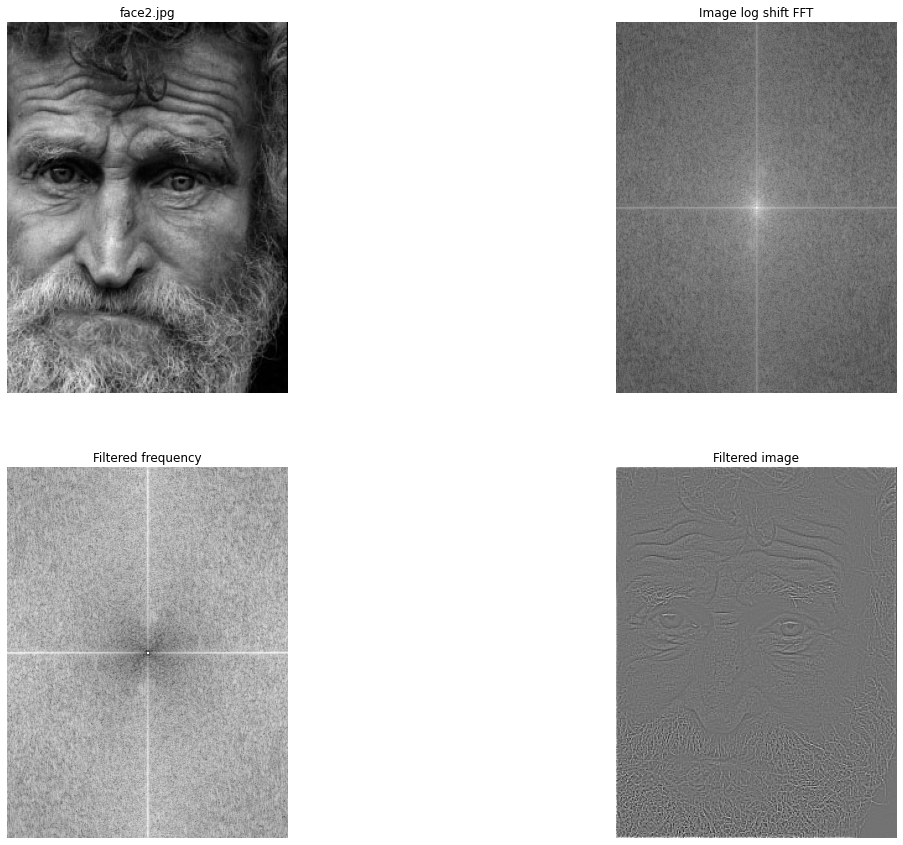

In [12]:
# 4.highlight the wrinkles of face2.jpg
loc = IMDIR+'Frequency/face2.jpg'
img = io.imread(loc, as_gray=True)

plt.figure()
plt.subplot(2,2,1)
plt.imshow(img, cmap='gray')
plt.title('face2.jpg')
plt.axis('off')

# compute the fft transform
P = img.shape[0]*2
Q = img.shape[1]*2

img_pad = np.zeros((P,Q))
img_pad[0:img.shape[0],0:img.shape[1]] = img
img_fft = np.fft.fft2(img_pad)
img_shift = np.fft.fftshift(img_fft)

plt.subplot(2,2,2)
plt.imshow(np.log(np.abs(img_shift)), cmap='gray')
plt.title('Image log shift FFT')
plt.axis('off')

H = high_pass(P, Q, 'gaussian', 150)
G = H*img_shift
img_fil = np.real(np.fft.ifft2(np.fft.ifftshift(G))) 
img_fil = img_fil[0:img.shape[0],0:img.shape[1]]

plt.subplot(2,2,3)
plt.imshow(np.log(np.abs(G)), cmap='gray')
plt.title('Filtered frequency')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(img_fil, cmap='gray')
plt.title('Filtered image')
plt.axis('off')

<ipython-input-13-45df228bec02>:49: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(G)), cmap='gray')
<ipython-input-13-45df228bec02>:70: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(G)), cmap='gray')


(-0.5, 999.5, 823.5, -0.5)

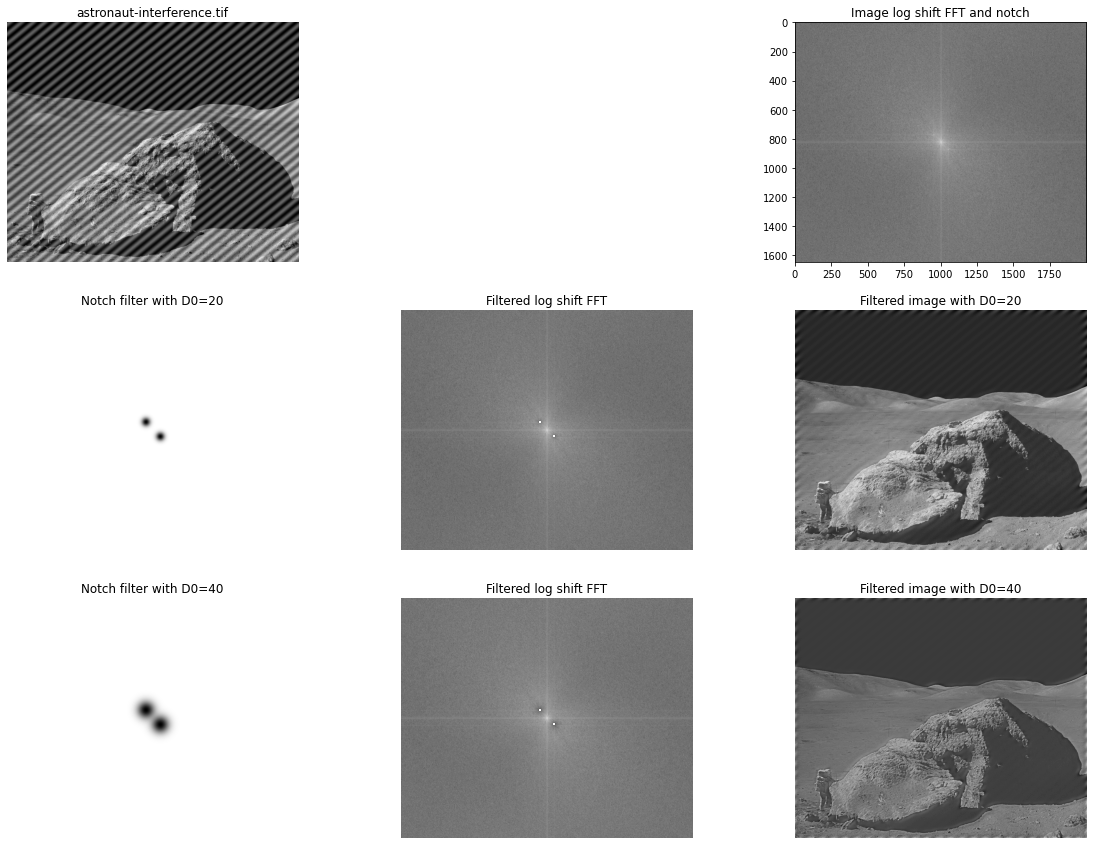

In [13]:
# 5. remove the interference pattern of astronaut-interference.tif
loc = IMDIR+'Frequency/astronaut-interference.tif'
img = io.imread(loc, as_gray=True)

plt.figure()
plt.subplot(3,3,1)
plt.imshow(img, cmap='gray')
plt.title('astronaut-interference.tif')
plt.axis('off')

# compute the fft transform
P = img.shape[0]*2
Q = img.shape[1]*2

img_pad = np.zeros((P,Q))
img_pad[0:img.shape[0],0:img.shape[1]] = img
img_fft = np.fft.fft2(img_pad)
img_shift = np.fft.fftshift(img_fft)

# pick the notch
# need to be improved
notch = [(768,952),(868,1050)]

plt.subplot(3,3,3)
plt.imshow(np.log(np.abs(img_shift)), cmap='gray')
plt.title('Image log shift FFT and notch')
#plt.axis('off')

# compute notch filter
Notch_filter20 = 1
Notch_filter40 = 1
for i in range(len(notch)):
    notch_filter20 = high_pass(P, Q, 'gaussian', 20, notch[i][0], notch[i][1])
    notch_filter40 = high_pass(P, Q, 'gaussian', 40, notch[i][0], notch[i][1])
    Notch_filter20 = Notch_filter20*notch_filter20
    Notch_filter40 = Notch_filter40*notch_filter40

G = img_shift*Notch_filter20
img_fil = np.real(np.fft.ifft2(np.fft.ifftshift(G))) 
img_fil = img_fil[0:img.shape[0],0:img.shape[1]]

plt.subplot(3,3,4)
plt.imshow(Notch_filter20, cmap='gray')
plt.title('Notch filter with D0=20')
plt.axis('off')


plt.subplot(3,3,5)
plt.imshow(np.log(np.abs(G)), cmap='gray')
plt.title('Filtered log shift FFT')
plt.axis('off')

plt.subplot(3,3,6)
plt.imshow(img_fil, cmap='gray')
plt.title('Filtered image with D0=20')
plt.axis('off')


G = img_shift*Notch_filter40
img_fil = np.real(np.fft.ifft2(np.fft.ifftshift(G))) 
img_fil = img_fil[0:img.shape[0],0:img.shape[1]]

plt.subplot(3,3,7)
plt.imshow(Notch_filter40, cmap='gray')
plt.title('Notch filter with D0=40')
plt.axis('off')


plt.subplot(3,3,8)
plt.imshow(np.log(np.abs(G)), cmap='gray')
plt.title('Filtered log shift FFT')
plt.axis('off')

plt.subplot(3,3,9)
plt.imshow(img_fil, cmap='gray')
plt.title('Filtered image with D0=40')
plt.axis('off')


<ipython-input-14-217f7d2a08bb>:32: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(G)), cmap='gray')


(-0.5, 771.5, 685.5, -0.5)

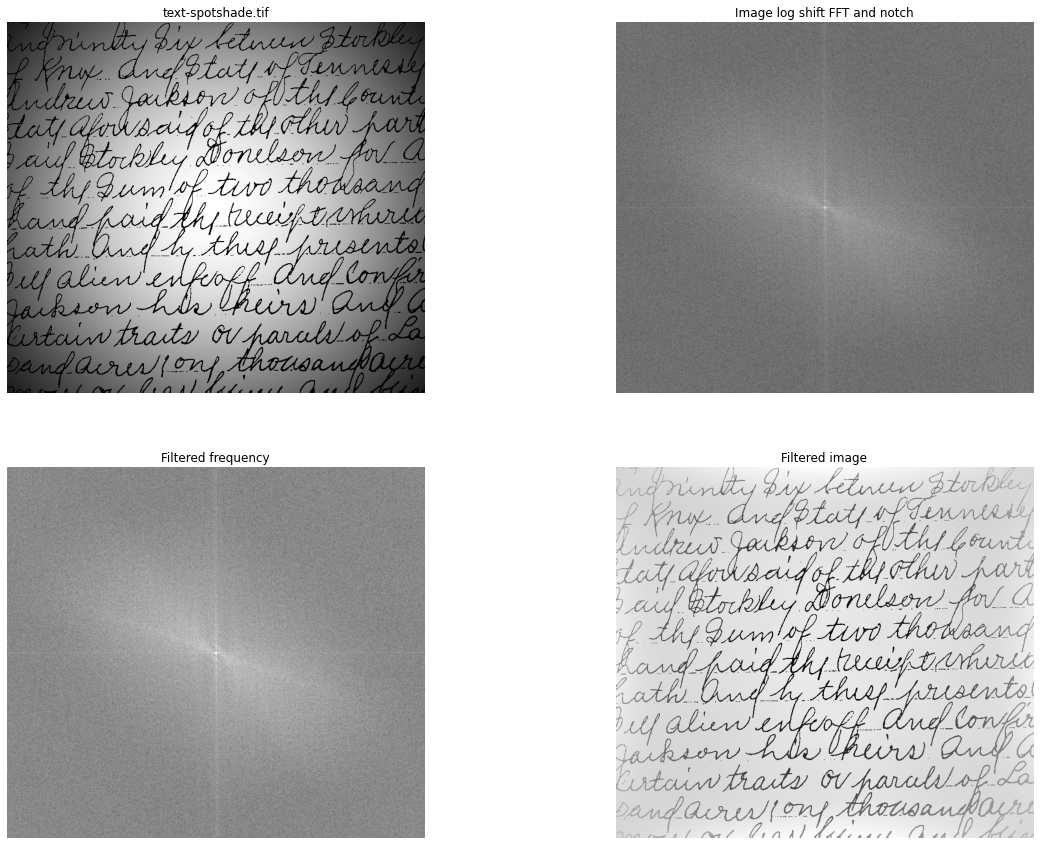

In [14]:
## 6. remove the shadow from the text-spotshade.tif
loc = IMDIR+'Frequency/text-spotshade.tif'
img = io.imread(loc, as_gray=True)

plt.figure()
plt.subplot(2,2,1)
plt.imshow(img, cmap='gray')
plt.title('text-spotshade.tif')
plt.axis('off')

# compute the fft transform
P = img.shape[0]*2
Q = img.shape[1]*2

img_pad = np.zeros((P,Q))
img_pad[0:img.shape[0],0:img.shape[1]] = img
img_fft = np.fft.fft2(img_pad)
img_shift = np.fft.fftshift(img_fft)

plt.subplot(2,2,2)
plt.imshow(np.log(np.abs(img_shift)), cmap='gray')
plt.title('Image log shift FFT and notch')
plt.axis('off')


H = high_pass(P, Q, 'gaussian', 5)
G = H*img_shift
img_fil = np.real(np.fft.ifft2(np.fft.ifftshift(G))) 
img_fil = img_fil[0:img.shape[0],0:img.shape[1]]

plt.subplot(2,2,3)
plt.imshow(np.log(np.abs(G)), cmap='gray')
plt.title('Filtered frequency')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(img_fil, cmap='gray')
plt.title('Filtered image')
plt.axis('off')

##  3. Towards JPEG Compression

**Introduction**

One of the crucial steps of JPEG Compression is the quantization in frequency space. The procedure follows the next steps:

**i)** An image is first subdivided in 8x8 subblocks (assuming the original image has sides whose length is a multiple of 8, if it is not the case just resize it).

**ii)** A frequency transformation is computed for each block (computed with a discrete cosine transform DCT II )
```
fftpack.dct(fftpack.dct(im.T, norm='ortho').T, norm='ortho')
```
**iii)** The DCT results are then divided by the elements of a predefined quantization matrix, then rounded and stored as integers. **Hint:** use functions  ```round()```, ```astype(np.int32)```

**iv)** The result of quantization (which should have many zeros) is then compressed Run Lenght Coding and Huffman coding to reduce the size. The compressed values are saved together with the quantization table.

**v)** The reconstruction of the image implies inverting the encoding, the quantization and the dct.

See more info in this video.
https://www.youtube.com/watch?v=Q2aEzeMDHMA



**What to implement**

In this part you will reproduce the steps regarding the DCT from the JPEG compression procedure, that is steps i) to iii). Pick a grayscale image of your choice (pick an image at least twice as 128 x 128), resize it if necessary.

**a)** Compute the frequency quantization step, using the provided ```quantization_table``` and ``dct_2d`` functions.

**b)** Restore the image from its quantized frequency representation.

**c)** Show the frequency spectrum  for some (or all) of the blocks before and after the quantization.

**d)** Show:
- the original image
- the quantized image 
- the difference between the two.

**e)** Repeat the above steps but resizing the input image to 128,128 first. What do you observe ?

**f)** Replace the given DCT function by your own basis implementation. Explain any difference.


**IN THE REPORT** Comment on your findings for questions d), e) and f)



In [16]:
from skimage.transform import resize
import scipy
from scipy import fftpack


def dct_2d(im):
    return fftpack.dct(fftpack.dct(im.T, norm='ortho').T, norm='ortho')

def idct_2d(im):
    return fftpack.idct(fftpack.idct(im.T, norm='ortho').T, norm='ortho')

def quantization_table(component='lum'):
    # Quantization Table for: Photoshop 
    # (http://www.impulseadventure.com/photo/jpeg-quantization.html)
    if component == 'lum':
        q = np.array([[2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 4, 5, 7, 9],
                      [2, 2, 2, 4, 5, 7, 9, 12],
                      [3, 3, 4, 5, 8, 10, 12, 12],
                      [4, 4, 5, 7, 10, 12, 12, 12],
                      [5, 5, 7, 9, 12, 12, 12, 12],
                      [6, 6, 9, 12, 12, 12, 12, 12]])
    elif component == 'chrom':
        q = np.array([[3, 3, 5, 9, 13, 15, 15, 15],
                      [3, 4, 6, 11, 14, 12, 12, 12],
                      [5, 6, 9, 14, 12, 12, 12, 12],
                      [9, 11, 14, 12, 12, 12, 12, 12],
                      [13, 14, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12]])
    else:
        raise ValueError((
            "component should be either 'lum' or 'chrom', "
            "but '{comp}' was found").format(comp=component))

    return q


im = scipy.misc.ascent().astype(float)
print(im.shape)



(512, 512)


(-0.5, 639.5, 426.5, -0.5)

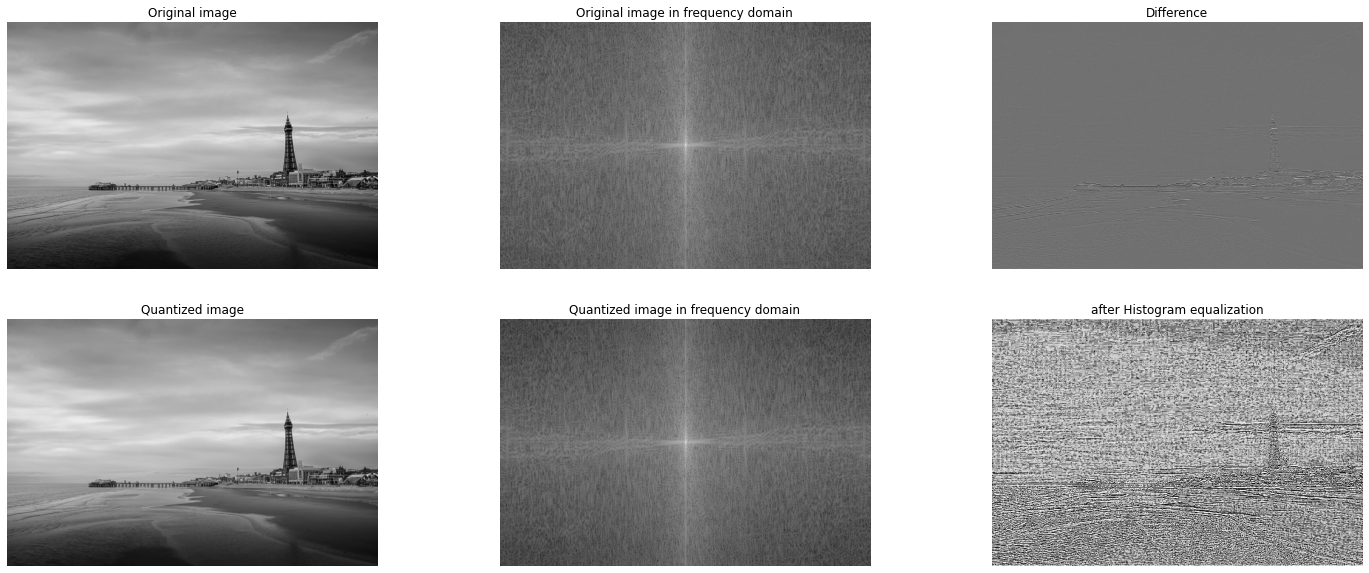

In [17]:
width=25
height=10
plt.rcParams['figure.figsize']=[width, height]

plt.figure()
plt.subplot(2,3,1)
loc = IMDIR+'jpeg/pink.jpg'
img = io.imread(loc, as_gray=True)
plt.imshow(img,cmap='gray')
plt.title('Original image')
plt.axis('off')

plt.subplot(2,3,2)
fft = np.fft.fft2(img)
img_shift = np.fft.fftshift(fft)
plt.imshow(np.log(np.abs(img_shift)),cmap='gray')
plt.title('Original image in frequency domain')
plt.axis('off')

# resize the image if it's not a multiple of 8
img_quan = img.copy()
if img_quan.shape[0]%8 !=0 or img_quan.shape[1]%8 !=0:
        w = img_quan.shape[1]//8
        h = img_quan.shape[0]//8
        if w > h:
            img_quan = resize(img_quan,(w*8,w*8),mode='constant')
        else:
            img_quan = resize(img_quan,(h*8,h*8),mode='constant')

img_quan = img_quan*255 -128
table = quantization_table(component='lum')
# compute the dct and quantization while subdivide image to several 8x8 blocks
for i in range(int(img_quan.shape[0]/8)):
    for j in range(int(img_quan.shape[1]/8)):
        v = img_quan[8*i:8*(i+1),8*j:8*(j+1)]
        dct = dct_2d(v)
        quantized = (dct/table).astype(np.int32)
        quantized = quantized*table
        idct = idct_2d(quantized)
        idct = idct + 128
        img_quan[8*i:8*(i+1),8*j:8*(j+1)] = idct
img_quan = resize(img_quan,(img.shape),mode='constant')
plt.subplot(2,3,4)
plt.imshow(img_quan,cmap='gray')
plt.title('Quantized image')
plt.axis('off')

plt.subplot(2,3,5)
fft = np.fft.fft2(img_quan)
img_quan_fft = np.fft.fftshift(fft)
plt.imshow(np.log(np.abs(img_quan_fft)),cmap='gray')
plt.title('Quantized image in frequency domain')
plt.axis('off')

diff = img*255-img_quan.astype(np.int32)
plt.subplot(2,3,3)
plt.imshow(diff,cmap='gray')
plt.title('Difference')
plt.axis('off')

diff = hist_equali(diff)
plt.subplot(2,3,6)
plt.imshow(diff,cmap='gray')
plt.title('after Histogram equalization')
plt.axis('off')


(-0.5, 127.5, 127.5, -0.5)

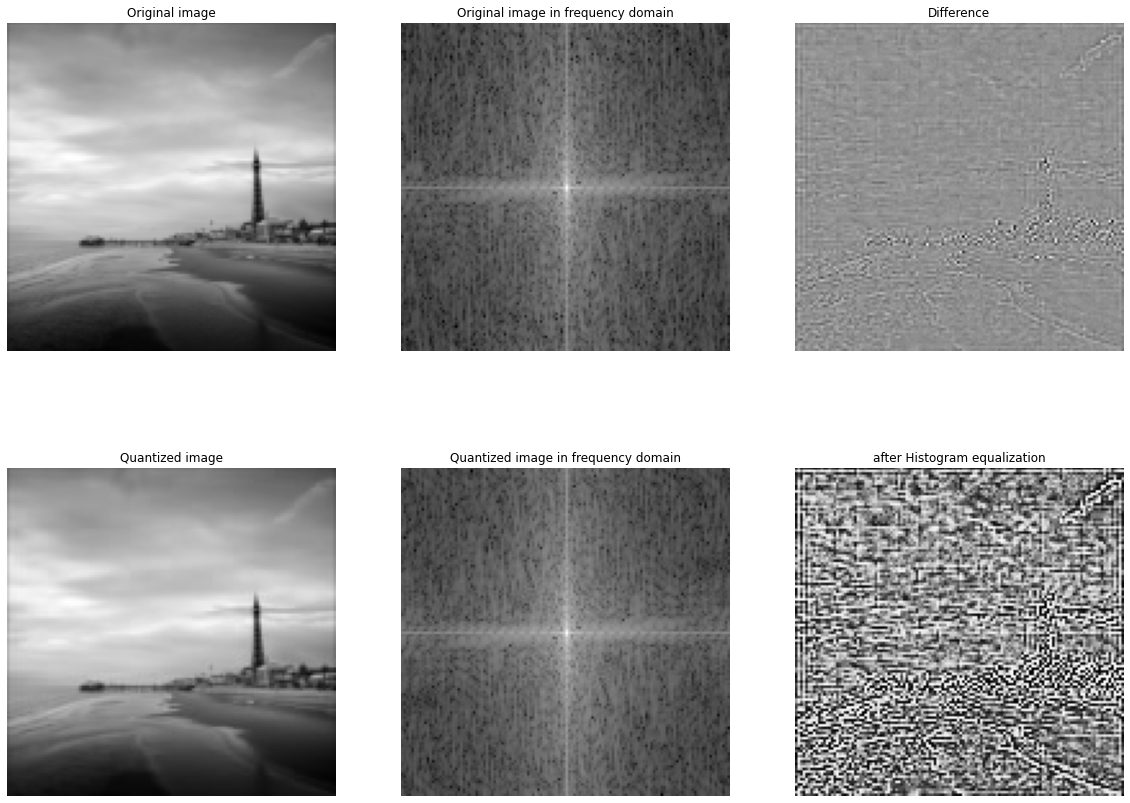

In [18]:
# resize image to 128x128 first
width=20
height=15
plt.rcParams['figure.figsize']=[width, height]

plt.figure()
plt.subplot(2,3,1)
loc = IMDIR+'jpeg/pink.jpg'
img = io.imread(loc, as_gray=True)
img = resize(img,(128,128), mode='constant')
plt.imshow(img,cmap='gray')
plt.title('Original image')
plt.axis('off')


plt.subplot(2,3,2)
fft = np.fft.fft2(img)
img_shift = np.fft.fftshift(fft)
plt.imshow(np.log(np.abs(img_shift)),cmap='gray')
plt.title('Original image in frequency domain')
plt.axis('off')

# resize the image if it's not a multiple of 8
img_quan = img.copy()
img_quan = img_quan*255 -128
table = quantization_table(component='lum')
# compute the dct and quantization while subdivide image to several 8x8 blocks
for i in range(int(img_quan.shape[0]/8)):
    for j in range(int(img_quan.shape[1]/8)):
        v = img_quan[8*i:8*(i+1),8*j:8*(j+1)]
        dct = dct_2d(v)
        quantized = (dct/table).astype(np.int32)
        quantized = quantized*table
        idct = idct_2d(quantized)
        idct = idct + 128
        img_quan[8*i:8*(i+1),8*j:8*(j+1)] = idct
img_quan = resize(img_quan,(img.shape),mode='constant')
plt.subplot(2,3,4)
plt.imshow(img_quan,cmap='gray')
plt.title('Quantized image')
plt.axis('off')

plt.subplot(2,3,5)
fft = np.fft.fft2(img_quan)
img_quan_fft = np.fft.fftshift(fft)
plt.imshow(np.log(np.abs(img_quan_fft)),cmap='gray')
plt.title('Quantized image in frequency domain')
plt.axis('off')

diff = img*255-img_quan.astype(np.int32)
plt.subplot(2,3,3)
plt.imshow(diff,cmap='gray')
plt.title('Difference')
plt.axis('off')

diff = hist_equali(diff)
plt.subplot(2,3,6)
plt.imshow(diff,cmap='gray')
plt.title('after Histogram equalization')
plt.axis('off')

In [19]:
# Replace the given DCT function by your own basis implementation. Explain any difference.
def my_dct(img):
    a = np.zeros((8,8))
    h = img.shape[1]
    for i in range(8):
        for j in range(8):
            if(i == 0):
                x = np.sqrt(1/h)
            else:
                x = np.sqrt(2/h)
            a[i,j] = x*np.cos(np.pi*(j + 0.5)*i/h)
    a_T = a.transpose()
    y = np.dot(a,img)
    out = np.dot(y,a_T)
    
    return out

Text(0.5, 1.0, 'after Histogram equalization')

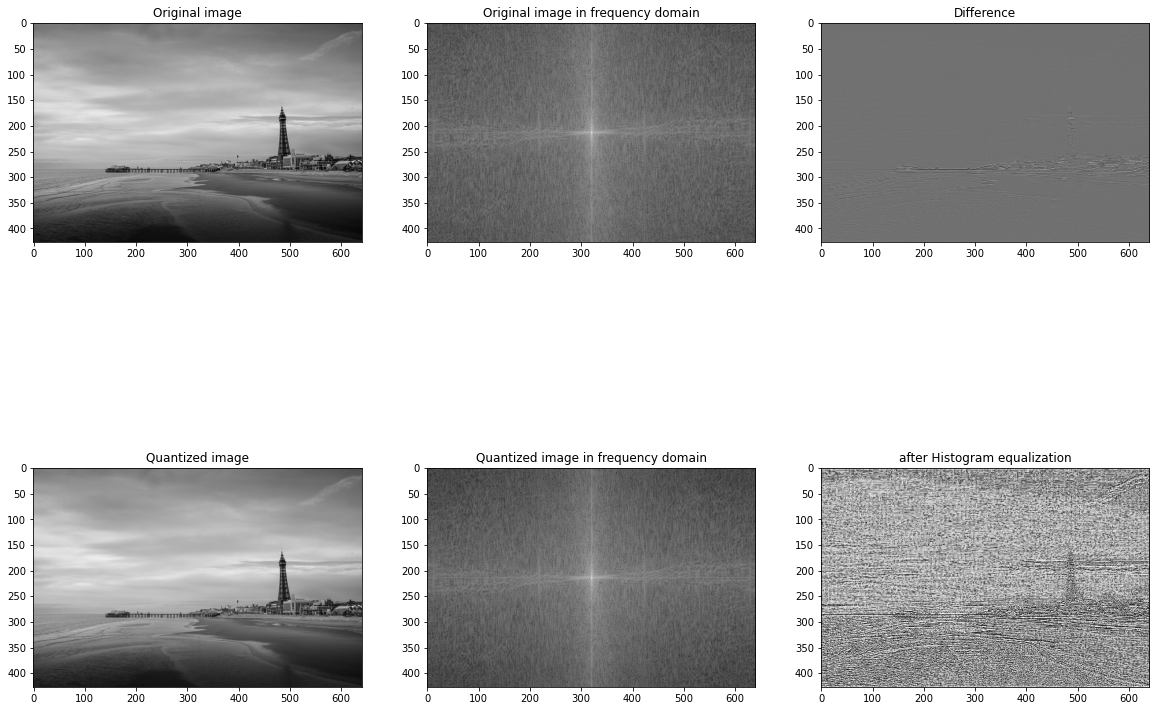

In [20]:
width=20
height=15
plt.rcParams['figure.figsize']=[width, height]

plt.figure()
plt.subplot(2,3,1)
loc = IMDIR+'jpeg/pink.jpg'
img = io.imread(loc, as_gray=True)
plt.imshow(img,cmap='gray')
plt.title('Original image')


plt.subplot(2,3,2)
fft = np.fft.fft2(img)
img_shift = np.fft.fftshift(fft)
plt.imshow(np.log(np.abs(img_shift)),cmap='gray')
plt.title('Original image in frequency domain')


# resize the image if it's not a multiple of 8
img_quan = img.copy()
if img_quan.shape[0]%8 !=0 or img_quan.shape[1]%8 !=0:
        w = img_quan.shape[1]//8
        h = img_quan.shape[0]//8
        if w > h:
            img_quan = resize(img_quan,(w*8,w*8),mode='constant')
        else:
            img_quan = resize(img_quan,(h*8,h*8),mode='constant')

img_quan = img_quan*255 -128
table = quantization_table(component='lum')
# compute the dct and quantization while subdivide image to several 8x8 blocks
for i in range(int(img_quan.shape[0]/8)):
    for j in range(int(img_quan.shape[1]/8)):
        v = img_quan[8*i:8*(i+1),8*j:8*(j+1)]
        dct = my_dct(v)
        quantized = (dct/table).astype(np.int32)
        quantized = quantized*table
        idct = idct_2d(quantized)
        idct = idct + 128
        img_quan[8*i:8*(i+1),8*j:8*(j+1)] = idct
img_quan = resize(img_quan,(img.shape),mode='constant')
plt.subplot(2,3,4)
plt.imshow(img_quan,cmap='gray')
plt.title('Quantized image')

plt.subplot(2,3,5)
fft = np.fft.fft2(img_quan)
img_quan_fft = np.fft.fftshift(fft)
plt.imshow(np.log(np.abs(img_quan_fft)),cmap='gray')
plt.title('Quantized image in frequency domain')

diff = img*255-img_quan.astype(np.int32)
plt.subplot(2,3,3)
plt.imshow(diff,cmap='gray')
plt.title('Difference')

diff = hist_equali(diff)
plt.subplot(2,3,6)
plt.imshow(diff,cmap='gray')
plt.title('after Histogram equalization')

### 4. BONUS: Magnitude and phase of the FFT  

**a)** Load the ```wolf.jpg``` and ```cat.jpg``` images inside the ```PhaseMag``` folder. Use ```im = misc.imresize(im,(100,100))```  to resize the two images such that both have the same size.

**b)** Compute the fft of each image

**c)** Display the centered and logarithmically scaled magnitude of each fft (same as 1.1)

**d)** Compute and display the phase of the fft

**e)** Reconstruct the ```cat``` and the ```wolf``` images only from their **magnitude** (set the phase to 0). Display the result in a logarithmic scale.

**f)** Reconstruct the ```cat``` and the ```wolf``` images only from their **phase** (set the magnitude to 1) 

**g)** Reconstruct an image with the magnitude of the wolf's fft and the phase of the cat's fft. 

**h)** Explain what you observe

**Hints**: You may want use the following functions:
- ```np.abs``` and ```np.angle``` to extract the magnitude and phase of a complex number.
- ```magnitude * np.exp (1j * phase)``` to build a complex number from its magnitude and phase.
- ```np.cos``` and  ```np.sin``` to build a complex number from its real and imaginary part ( $real + 1j*imaginary$)


**IN THE REPORT**: What do we observe and why?

(-0.5, 99.5, 99.5, -0.5)

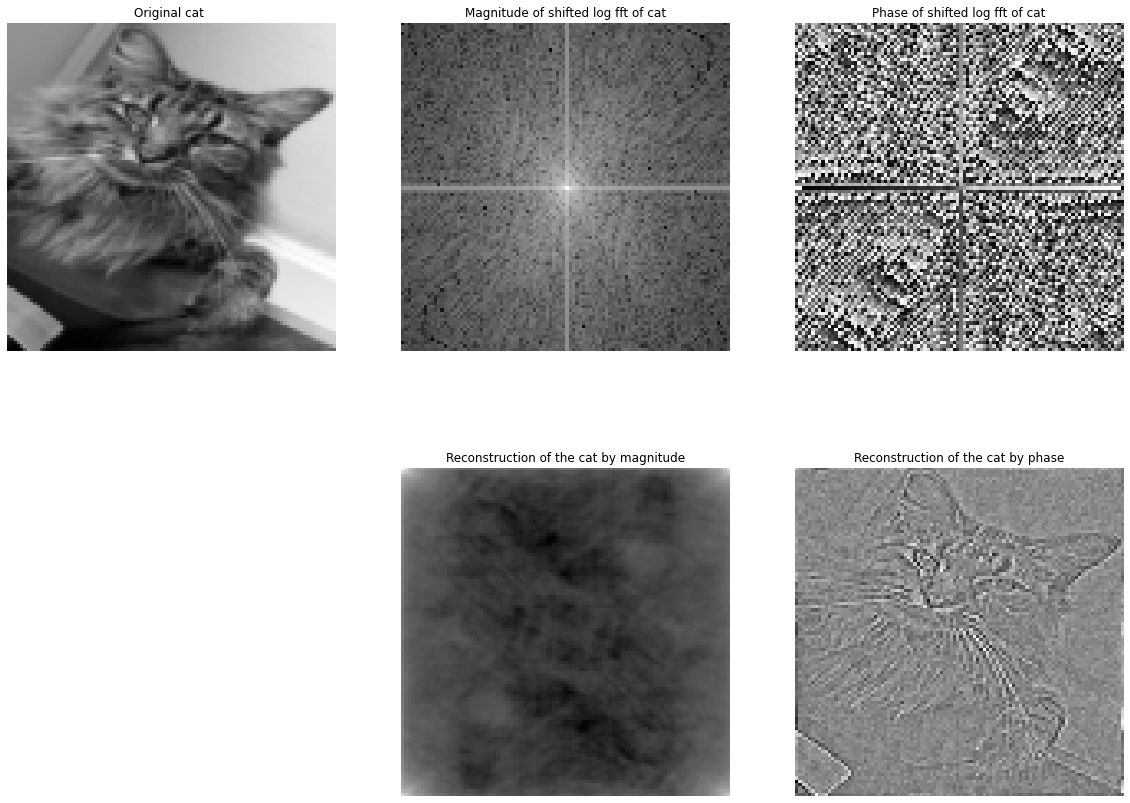

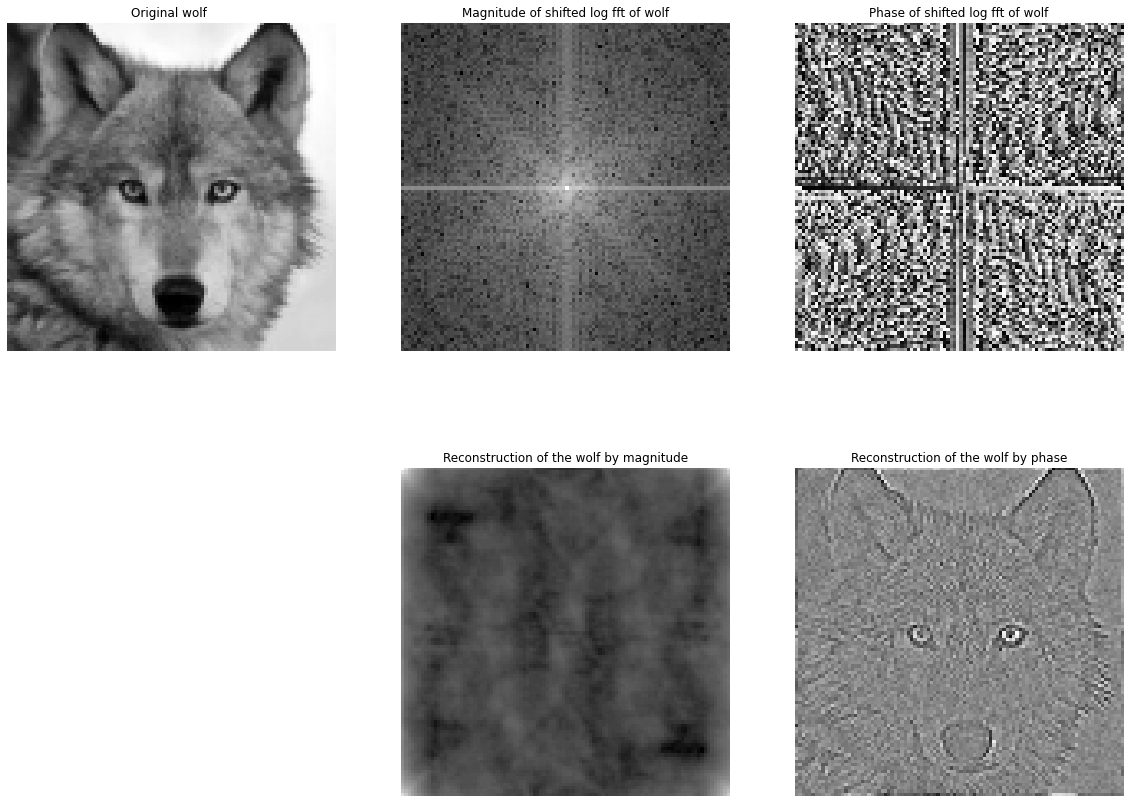

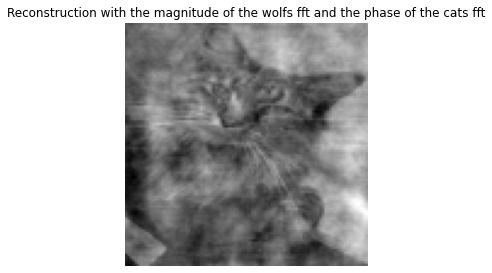

In [21]:
loc = IMDIR+'./PhaseMag/cat.jpg'
img_cat = io.imread(loc, as_gray=True)
img_cat = 255*resize(img_cat,(100,100))
loc = IMDIR+'./PhaseMag/wolf.jpg'
img_wolf = io.imread(loc, as_gray=True)
img_wolf = 255*resize(img_wolf,(100,100))


cat_fft = np.fft.fft2(img_cat)
cat_shift = np.fft.fftshift(cat_fft)
wolf_fft = np.fft.fft2(img_wolf)
wolf_shift = np.fft.fftshift(wolf_fft)

cat_mag = np.abs(cat_fft)
cat_pha = np.exp(1j*np.angle(cat_fft))
wolf_mag = np.abs(wolf_fft)
wolf_pha = np.exp(1j*np.angle(wolf_fft))

cat_wolf = wolf_mag*cat_pha

#cat
plt.figure()
plt.subplot(2,3,1)
plt.imshow(img_cat, cmap='gray')
plt.title('Original cat ')
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(np.log(np.abs(cat_shift)), cmap='gray')
plt.title('Magnitude of shifted log fft of cat')
plt.axis('off')


plt.subplot(2,3,3)
plt.imshow(np.angle(cat_shift), cmap='gray')
plt.title('Phase of shifted log fft of cat')
plt.axis('off')

plt.subplot(2,3,5)
re_cat_mag = np.log(np.real(np.fft.ifft2(cat_mag)))
plt.imshow(re_cat_mag, cmap='gray')
plt.title('Reconstruction of the cat by magnitude')
plt.axis('off')

plt.subplot(2,3,6)
re_cat_pha = np.real(np.fft.ifft2(cat_pha))
plt.imshow(re_cat_pha, cmap='gray')
plt.title('Reconstruction of the cat by phase')
plt.axis('off')

#wolf
plt.figure()
plt.subplot(2,3,1)
plt.imshow(img_wolf, cmap='gray')
plt.title('Original wolf ')
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(np.log(np.abs(wolf_shift)), cmap='gray')
plt.title('Magnitude of shifted log fft of wolf')
plt.axis('off')


plt.subplot(2,3,3)
plt.imshow(np.angle(wolf_shift), cmap='gray')
plt.title('Phase of shifted log fft of wolf')
plt.axis('off')

plt.subplot(2,3,5)
re_wolf_mag = np.log(np.real(np.fft.ifft2(wolf_mag)))
plt.imshow(re_wolf_mag, cmap='gray')
plt.title('Reconstruction of the wolf by magnitude')
plt.axis('off')

plt.subplot(2,3,6)
re_wolf_pha = np.real(np.fft.ifft2(wolf_pha))
plt.imshow(re_wolf_pha, cmap='gray')
plt.title('Reconstruction of the wolf by phase')
plt.axis('off')


#cat and wolf
plt.figure()
plt.subplot(1,4,1)
re_catwolf = np.real(np.fft.ifft2(cat_wolf))
plt.imshow(re_catwolf, cmap='gray')
plt.title('Reconstruction with the magnitude of the wolf''s fft and the phase of the cat''s fft')
plt.axis('off')
